# Assignment 3: ICP + Non-linear least squares optimization

TEAM-ID:   
TEAM-NAME:   
YOUR-ID:   
YOUR-NAME:   

(Although you work in groups, both the students have to submit to Moodle, hence there's name field above)


## Instructions

* Please check Moodle for "TEAM-ID" and "TEAM-NAME" fields above. Some of your names have been edited because of redundancy/simplicity. Instructions for submitting the assignment through GitHub Classrooms/Moodle has been uploaded on Moodle. Any clarifications will be made there itself.
* Code must be written in Python in Jupyter Notebooks. You can use Assignment-1's environment for this assignment. More instructions for setup provided as you progress through this assignment.
* Both the team members must submit the zip file.
* You are not allowed to use any external libraries (other than ones being imported below).
* Answer the descriptive questions in your own words with context & clarity. Do not just copy-paste from some Wikipedia page. You will be evaluated accordingly.
* You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.

In [ ]:
# Only allowed to use these libraries for this assignment. 
# Setup: Just activate Assignment-1's environment and install matplotlib `python -m pip install -U matplotlib`

import numpy as np
import math
import matplotlib as mpl # only to make matplotlib graphs larger and readable, used on line 11 of this cell
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # for the 3D plot in the explanation of Q1.1, part of matplotlib, no auxillary installations required
import time

mpl.rcParams['figure.dpi'] = 110
plt.style.use('seaborn-bright')

# Question 1: Simple Non-Linear least squares for Gaussian function

First, go through the [solved example here](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-13cf17d318be4d45bb8577c4d3ea4a02#1de60a8465664d39a12af24353feef9e) from the [notes page](https://www.notion.so/saishubodh/Mobile-Robotics-2020-Students-Page-0b65a9c20edd4081978f4ffad917febb#a68cabac64754fa485144cc89b4b8c65). After understanding this, 

(1.1) Code it from scratch using `numpy` and try it out yourself for say different number of iterations with a certain tolerance for all 50 observations using Gradient Descent. Make the following plots using `matplotlib`:
   * Data and fit plot: Ground truth Gaussian, observations (points) & predicted Gaussian on the same plot.
   * Cost function ($\|r\|^2$) vs number of iterations   
   
Experiment with the hyperparameters and compile your observations in a table. Clearly mention your hyperparameters with justification.

(1.2) You've used Gradient Descent above. Now implement Gauss-Newton and LM algorithms. To contrast between the three, you must experiment with 
   * Different initial estimate: Can a particular algorithm handle if the initial estimate is too far from GT?
   * Different number of observations: Can a particular algorithm handle very less observations?
   * Add [noise](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) to your observations: Can a particular algorithm handle large noise?
   * What else can you think of? (For example, can an algorithm converge in less iterations compared to others?)
    
Make the plots (mentioned in 1.1) for all 3 algorithms. Report your observations in a table(s) (comparison between the three for different factors). You will be awarded depending on how comprehensive your experimentation is (which you have to explain below under "**Answers for Question 1**" section).

## Code for Question 1

In [ ]:
# Only numpy & matplotlib is sufficient for this question.
##############################################################################
# TODO: Do tasks described in Question 1                                     #
##############################################################################

# CONSTANTS

# Ground Truth
ACTUAL_AMP = 10
ACTUAL_MEAN = 0
ACTUAL_SD = 20

# Data Generation
NUM_OBS = 50
X_RANGE = (-25, 25)
NOISE_MEAN = 0
NOISE_VAR = 1

# Hyperparameters
GD_LEARN_RATE = 1e-2
LM_LAMBDA = 1
NUM_ITERS = 200
TOL = 1e-6

# Initialization
INIT_AMP = 10
INIT_MEAN = 13
INIT_SD = 19.12

# Utility
PLOT_RANGE = (-50, 50)
FIG_SIZE = (10, 3.5)

In [ ]:
# UTILITY FUNCTIONS

def gaussian(amp, mu, sigma, x):
    return amp * np.exp(-((x - mu) ** 2)/(2 * (sigma ** 2)))

def generate_data(amp, mu, sigma, x_range, num_obs, noise=False, noise_mean=0, noise_var=1):
    x = np.linspace(*x_range, num_obs)
    y = gaussian(amp, mu, sigma, x)
    
    if noise:
        y += np.random.normal(noise_mean, noise_var, y.shape)
        
    return x, y

def plot_gaussian(plot, amp, mu, sigma, x_range=PLOT_RANGE, color=None, legend=None):
    '''generates its own datapoints to create the plot'''
    x, y = generate_data(amp, mu, sigma, x_range, 100)
    plot.plot(x, y, color=color, label=legend, alpha=0.7)

def plot_points(plot, x, y, color=None, legend=None):
    plot.scatter(x, y, marker='o', color=color, alpha=0.4, label=legend)

In [ ]:
# ACTUAL STUFF

def residual(amp, mu, sigma, x, y):
    return gaussian(amp, mu, sigma, x) - y

def error(amp, mu, sigma, x, y):
    return np.linalg.norm(residual(amp, mu, sigma, x, y)) ** 2

def jacobian(amp, mu, sigma, x):
    exp = gaussian(1, mu, sigma, x)
    return np.c_[exp, amp * (x - mu) * exp / (sigma ** 2), amp * ((x - mu) ** 2) * exp / (sigma ** 3)]

def step_gd(amp, mu, sigma, x, y, alpha):
    J = jacobian(amp, mu, sigma, x)
    r = residual(amp, mu, sigma, x, y)
    return -alpha * (J.T @ r)

def step_gn(amp, mu, sigma, x, y):
    J = jacobian(amp, mu, sigma, x)
    r = residual(amp, mu, sigma, x, y)
    return -np.linalg.pinv(J.T @ J) @ J.T @ r

def step_lm(amp, mu, sigma, x, y, lamda):
    J = jacobian(amp, mu, sigma, x)
    r = residual(amp, mu, sigma, x, y)
    return -np.linalg.pinv((J.T @ J) + (lamda * np.eye(J.shape[1]))) @ J.T @ r

In [ ]:
# DESCENT ALGORITHMS

def gradient_descent(amp_0, mu_0, sigma_0, x, y, alpha=GD_LEARN_RATE, num_iters=NUM_ITERS, tol=TOL):
    params = np.array([amp_0, mu_0, sigma_0], dtype=np.double)
    errors = [error(*params, x, y), ]
    
    for _ in range(num_iters):
        new_params = params + step_gd(*params, x, y, alpha)
        errors.append(error(*new_params, x, y))
        
        if np.linalg.norm(new_params - params) < tol:
            params = new_params
            break
            
        params = new_params
        
    return new_params, errors

def gauss_newton(amp_0, mu_0, sigma_0, x, y, num_iters=NUM_ITERS, tol=TOL):
    params = np.array([amp_0, mu_0, sigma_0], dtype=np.double)
    errors = [error(*params, x, y), ]
    
    for _ in range(num_iters):
        new_params = params + step_gn(*params, x, y)
        errors.append(error(*new_params, x, y))
        
        if np.linalg.norm(new_params - params) < tol:
            params = new_params
            break
            
        params = new_params
        
    return new_params, errors

def levenberg_marquardt(amp_0, mu_0, sigma_0, x, y, lamda=LM_LAMBDA, num_iters=NUM_ITERS, tol=TOL):
    params = np.array([amp_0, mu_0, sigma_0], dtype=np.double)
    errors = [error(*params, x, y), ]
    
    for _ in range(num_iters):
        new_params = params + step_lm(*params, x, y, lamda)
        new_error = error(*new_params, x, y)
        if len(errors) > 0:
            if new_error > errors[-1]:
                lamda = lamda * 2
            else:
                lamda = lamda / 3
        errors.append(new_error)
        
        if np.linalg.norm(new_params - params) < tol:
            params = new_params
            break
            
        params = new_params
        
    return new_params, errors
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

### Basic Algorithm Runs

In [ ]:
# Define the plots inside a function above and call them in this cell one by
# one. When I run this cell, all plots asked in Q1 should be generated. 
##############################################################################
# TODO: Plotting for Question 1                                              #
##############################################################################

# Gradient Descent
x, y = generate_data(ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, X_RANGE, NUM_OBS)
est_params, errors = gradient_descent(INIT_AMP, INIT_MEAN, INIT_SD, x, y)

fig, (axl, axr) = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle('Gradient Descent with default settings')
plot_gaussian(axl, ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, legend='Ground truth')
plot_gaussian(axl, *est_params, color='green', legend='Estimated')
plot_points(axl, x, y, color='red', legend='Observations')
axl.legend(loc='upper right')

axr.plot(errors, label='Cost')
axr.legend(loc='upper right')
print('Estimated Parameters:', est_params)
print('Cost:', errors[-1])
plt.show()



In [ ]:
# Gauss Newton
x, y = generate_data(ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, X_RANGE, NUM_OBS)
est_params, errors = gauss_newton(INIT_AMP, INIT_MEAN, INIT_SD, x, y)

fig, (axl, axr) = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle('Gauss Newton with default settings')
plot_gaussian(axl, ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, legend='Ground truth')
plot_gaussian(axl, *est_params, color='green', legend='Estimated')
plot_points(axl, x, y, color='red', legend='Observations')
axl.legend(loc='upper right')

axr.plot(errors, label='Cost')
axr.legend(loc='upper right')
print('Estimated Parameters:', est_params)
print('Cost:', errors[-1])
plt.show()

In [ ]:
# Levenberg Marquardt
x, y = generate_data(ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, X_RANGE, NUM_OBS)
est_params, errors = levenberg_marquardt(INIT_AMP, INIT_MEAN, INIT_SD, x, y)

fig, (axl, axr) = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle('Levenberg Marquardt with default settings')
plot_gaussian(axl, ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, legend='Ground truth')
plot_gaussian(axl, *est_params, color='green', legend='Estimated')
plot_points(axl, x, y, color='red', legend='Observations')
axl.legend(loc='upper right')

axr.plot(errors, label='Cost')
axr.legend(loc='upper right')
print('Estimated Parameters:', est_params)
print('Cost:', errors[-1])
plt.show()

### Gradient Descent Hyperparameters

In [ ]:
# Varying the learning rate
x, y = generate_data(ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, X_RANGE, NUM_OBS)

fig, (axl, axr) = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle('Gradient Descent with varying learning rates')
plot_gaussian(axl, ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, color='black', legend='Ground truth')
plot_points(axl, x, y, color='black', legend='Observations')

alphas = np.geomspace(1e-4, 1e-1, 4)
for alpha in alphas:
    est_params, errors = gradient_descent(INIT_AMP, INIT_MEAN, INIT_SD, x, y, alpha=alpha)
    plot_gaussian(axl, *est_params, legend=str(alpha))
    axr.plot(errors)

axr.set_ylim([-250, 5000])
fig.legend(title='Varying Alpha')

plt.show()

In [ ]:
# Varying Initial Amplitudes
x, y = generate_data(ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, X_RANGE, NUM_OBS)

fig, (axl, axr) = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle('Gradient Descent with varying initial amplitudes')
plot_gaussian(axl, ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, color='black', legend='Ground truth')
plot_points(axl, x, y, color='black', legend='Observations')

amps = [0, 13, 50]
for amp in amps:
    est_params, errors = gradient_descent(amp, INIT_MEAN, INIT_SD, x, y)
    plot_gaussian(axl, *est_params, legend=str(amp))
    axr.plot(errors)

fig.legend(title='Varying amplitudes')

plt.show()

In [ ]:
# Varying Initial Means
x, y = generate_data(ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, X_RANGE, NUM_OBS)

fig, (axl, axr) = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle('Gradient Descent with varying initial means')
plot_gaussian(axl, ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, color='black', legend='Ground truth')
plot_points(axl, x, y, color='black', legend='Observations')

mus = [0, 5, 10, 50]
for mu in mus:
    est_params, errors = gradient_descent(INIT_AMP, mu, INIT_SD, x, y)
    plot_gaussian(axl, *est_params, legend=str(mu))
    axr.plot(errors)

fig.legend(title='Varying means')

plt.show()

In [ ]:
# Varying Initial Standard Deviations
x, y = generate_data(ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, X_RANGE, NUM_OBS)

fig, (axl, axr) = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle('Gradient Descent with varying initial standard deviations')
plot_gaussian(axl, ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, color='black', legend='Ground truth')
plot_points(axl, x, y, color='black', legend='Observations')

sigmas = [16, 19.12, 20, 30]
for sigma in sigmas:
    est_params, errors = gradient_descent(INIT_AMP, INIT_MEAN, sigma, x, y)
    plot_gaussian(axl, *est_params, legend=str(sigma))
    axr.plot(errors)

fig.legend(title='Varying standard deviations')

plt.show()

### Comparison between the three

In [ ]:
# Poor Initialisation
x, y = generate_data(ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, X_RANGE, NUM_OBS)

fig, (axl, axr) = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle('Performance with poor initialisation')
plot_gaussian(axl, ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, color='black', legend='Ground truth')
plot_points(axl, x, y, color='black', legend='Observations')

initial = (50, 24, 22)

est_params, errors = gradient_descent(*initial, x, y)
plot_gaussian(axl, *est_params, legend='Gradient Descent')
axr.plot(errors)
print('GRADIENT DESCENT:')
print('Estimated parameters:', est_params)
print('Cost:', errors[-1])

est_params, errors = gauss_newton(*initial, x, y)
plot_gaussian(axl, *est_params, legend='Gauss Newton')
axr.plot(errors)
print('\nGAUSS NEWTON:')
print('Estimated parameters:', est_params)
print('Cost:', errors[-1])

est_params, errors = levenberg_marquardt(*initial, x, y)
plot_gaussian(axl, *est_params, legend='Levenberg Marquardt')
axr.plot(errors)
print('\nLEVENBERG MARQUARDT:')
print('Estimated parameters:', est_params)
print('Cost:', errors[-1])

axr.set_ylim([-250, 5000])
fig.legend()
plt.show()

In [ ]:
# Very Few Observations
x, y = generate_data(ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, X_RANGE, 5)

fig, (axl, axr) = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle('Performance with very few observations')
plot_gaussian(axl, ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, color='black', legend='Ground truth')
plot_points(axl, x, y, color='black', legend='Observations')

est_params, errors = gradient_descent(INIT_AMP, INIT_MEAN, INIT_SD, x, y)
plot_gaussian(axl, *est_params, legend='Gradient Descent')
axr.plot(errors)
print('GRADIENT DESCENT:')
print('Estimated parameters:', est_params)
print('Cost:', errors[-1])

est_params, errors = gauss_newton(INIT_AMP, INIT_MEAN, INIT_SD, x, y)
plot_gaussian(axl, *est_params, legend='Gauss Newton')
axr.plot(errors)
print('\nGAUSS NEWTON:')
print('Estimated parameters:', est_params)
print('Cost:', errors[-1])

est_params, errors = levenberg_marquardt(INIT_AMP, INIT_MEAN, INIT_SD, x, y)
plot_gaussian(axl, *est_params, legend='Levenberg Marquardt')
axr.plot(errors)
print('\nLEVENBERG MARQUARDT:')
print('Estimated parameters:', est_params)
print('Cost:', errors[-1])

fig.legend()
plt.show()

In [ ]:
# Performance on noisy data
x, y = generate_data(ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, X_RANGE, NUM_OBS, noise=True, noise_var=2)

fig, (axl, axr) = plt.subplots(1, 2, figsize=FIG_SIZE)
fig.suptitle('Performance on noisy data')
plot_gaussian(axl, ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, color='black', legend='Ground truth')
plot_points(axl, x, y, color='black', legend='Observations')

est_params, errors = gradient_descent(INIT_AMP, INIT_MEAN, INIT_SD, x, y)
plot_gaussian(axl, *est_params, legend='Gradient Descent')
axr.plot(errors)
print('GRADIENT DESCENT:')
print('Estimated parameters:', est_params)
print('Cost:', errors[-1])

est_params, errors = gauss_newton(INIT_AMP, INIT_MEAN, INIT_SD, x, y)
plot_gaussian(axl, *est_params, legend='Gauss Newton')
axr.plot(errors)
print('\nGAUSS NEWTON:')
print('Estimated parameters:', est_params)
print('Cost:', errors[-1])

est_params, errors = levenberg_marquardt(INIT_AMP, INIT_MEAN, INIT_SD, x, y)
plot_gaussian(axl, *est_params, legend='Levenberg Marquardt')
axr.plot(errors)
print('\nLEVENBERG MARQUARDT:')
print('Estimated parameters:', est_params)
print('Cost:', errors[-1])

fig.legend()
plt.show()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

## Answers for Question 1
Add explanations for the answers along with tables here.

In [ ]:
x, y = generate_data(ACTUAL_AMP, ACTUAL_MEAN, ACTUAL_SD, X_RANGE, NUM_OBS)

mus = np.linspace(ACTUAL_MEAN - 100, ACTUAL_MEAN + 100, 200)
sigmas = np.linspace(ACTUAL_SD - 100, ACTUAL_SD + 100, 200)

Mus, Sigmas = np.meshgrid(mus, sigmas)
errs = np.array([error(ACTUAL_AMP, mu, sigma, x, y) for mu, sigma in zip(np.ravel(Mus), np.ravel(Sigmas))])
Errs = errs.reshape(Mus.shape)

fig = plt.figure()
axs = fig.add_subplot(111, projection='3d')
axs.plot_surface(Mus, Sigmas, Errs, cmap=mpl.cm.coolwarm, linewidth=0, alpha=0.7)
axs.plot(ACTUAL_MEAN, ACTUAL_SD, 0, color='black', marker='X')
axs.set_xlabel('\nMean')
axs.set_ylabel('\nStandard Deviation')
axs.set_zlabel('\nError')
fig.suptitle('Non linear least squares cost function')
plt.show()

### Answer for 1.1
Explain your experimentations with justification here
The surface plot above shows the variation of the non-linear-least-sqaures (for a gaussian) cost function ($L_2$ norm of the residual) with the estimated mean and standard deviation (estimated amplitude omitted for sake of visualisation). The non-convex nature of this optimization makes iterative algorithms like gradient descent susceptible to poor initialization or choice of hyperparameters.

**Learning Rate**\
While a higher learning rate makes the algorithm converge towards the minima faster (and hence achieve a better estimate in the limited 200 interations), setting too high a learning rate causes the algorithm to misbehave and diverge (such as when $\alpha=0.1$ in the plot).

**Initialization**\
An initialization that is far from the actual minima can severely affect the performance of the algorithm. Depending on the gradients around the initialization point, it can either merely slow the rate of convergence, or even cause the algorithm to get stuck in a different local minima if the gradients point towards it. This is visible when the initial $\sigma$ is set to $30$ (It has a lower initial cost - however the cost stagnates at a higher value than the minimum cost).

**Number of Iterations**\
As the *Iterations vs Cost* plots show, gradient descent takes larger leaps in the beginnning and smaller ones as it closes in towards the minima (this is because the gradients are steeper far away and shallower closer to the minima). This stagnation means that although it still improves in each step, the improvements are minor and hence of not much significance after, in this case, 200 iterations.

**Fewer Observations**\
The number of observations affects gradient descent - as the quality of estimates and rate of convergence deteriorate with a decrease in the number of observations. This is because a decrease in the number of observations flattens the cost function and reduces the gradients - making them difficult to follow for gradient descent.

**Noise**\
Gradient descent performs relatively well with noisy data. While the estimates are off as compared to those with noiseless data, that is to be expected.

**Experiment**|**Initialisation**|**Learning Rate**|**Number of Iterations**|**Number of Observations**|**Noise**|**Estimated Parameters**|**Cost**
:-----|-----|-----|-----|-----|-----|-----|-----
Default run|10, 13, 19.12|0.01|200|50|0, 0|9.79, 0.22, 21.25|1.78
Low learning rate|10, 13, 19.12|0.001|200|50|0, 0|9.76, 8.54, 22.17|150.75
High learning rate|10, 13, 19.12|0.1|200|50|0, 0|-125.52, 80.49, -9.05|3,226.68
Poor initialisation for amplitude|50, 13, 19.12|0.01|200|50|0, 0|9.63, 23.10, 36.58|263.61
Poor initialisation for mean|10, 50, 19.12|0.01|200|50|0, 0|9.71, 31.63, 47.99|233.92
Poor initialisation for standard deviation|10, 13, 30|0.01|200|50|0, 0|8.93, 3.22, 29.76|50.61
Fewer observations|10, 13, 19.12|0.01|200|5|0, 0|9.54, 8.21, 21.73|16.06
Noisy data*|10, 13, 19.12|0.01|200|50|0, 2|9.71, 0.52, 18.96|247.06

### Answer for 1.2
While optimising a non-linear least squares formulation, we linearise the cost function in the neighbourhood of our current estimate, using the gradients to estimate the next guess. While gradient descent simply moves in the oppositve direction of the gradient, Gauss-Newton uses the closed-form solution of the locally-linear least-squares approximation to arrive at the next estimate. Levenberg-Marquardt balances between these two approaches, using a damping factor, $\lambda$, which also imparts numerical stability (ensures that $J^{T}J + \lambda I$ is full rank and hence invertible). This allows Levenberg-Marquardt to follow the gradients when far from the minima, and follow the curvature when nearby (by adjusting the value of $\lambda$).

**Initialization**\
Both gradient descent and Gauss-Newton fail to estimate the parameters correctly when the initialization is not close to the actual minima. Following the curvature takes Gauss-Newton to a different local minima, hence its estimates are off by a huge amount. Gradient descent, inspite of producing an even higher cost, makes an estimate which is closer to the actual. Levenberg-Marquardt, which initially follows the gradient to move in the right direction and then follows the curvature to quickly converge, is the only one that is able to estimate the parameters accurately.

**Number of Iterations**\
Both Gauss-Newton and Levenberg-Marquardt converge much quicker than gradient-descent. This is because they move to the minima of the local approximation of the function in each iteration, instead of just moving along the gradient by a constant amount.

**Fewer Observations**\
While both Gauss-Newton and Levenberg-Marquardt are resilient to a fewer number of observations, gradient descent's performance gets adversely affected. This is because a decrease in number of observations flattens the cost function and decreases the gradients - making it difficult for gradient descent to converge quickly.

**Noise**\
All the three algorithms work relatively well on noisy data, although, as usual, gradient descent converges much slower than the other two.

**Experiment**|**Setting**|**GD's Cost**|**GN's Cost**|**LM's Cost**|**GD's Iterations**|**GN's Iterations**|**LM's Iterations**
:-----|:-----|-----|-----|-----|-----|-----|-----
Default run|NA|1.78|0|~0|200|7|7
Poor initialisation|Initialised to 50, 24, 22|578.65|153.12|~0|200|10|10
Fewer observations|Trained on 5 observations|16.06|0|~0|200|10|10
Noisy data*|Random gaussian noise with $\mu = 0$ and $\sigma = 2$|204.03|201.5|201.5|200|10|10

_*Randomised data: Numbers are indicative and may vary._

# Question 2: ICP Coding
Implement basic ICP algorithm with (given) known correspondences. 

Let X be your point cloud observed from the initial position. Your robot moved and observed P1 as your current point cloud. Same with P2 under a different transformation. Now you wish to apply ICP to recover transformation between (X & P1) and (X & P2). Use *root mean squared error (rmse)* as the error metric.

In [ ]:
# HELPER FUNCTIONS: DON'T EDIT THIS BLOCK - If you want to test on more cases, you can add code to this block but
# DON'T delete existing code.


# Visualizing ICP registration
def plot_icp(X, P, P0, i, rmse):
  plt.cla()
  plt.scatter(X[0,:], X[1,:], c='k', marker='o', s=50, lw=0)
  plt.scatter(P[0,:], P[1,:], c='r', marker='o', s=50, lw=0)
  plt.scatter(P0[0,:], P0[1,:], c='b', marker='o', s=50, lw=0)
  plt.legend(('X', 'P', 'P0'), loc='lower left')
  plt.plot(np.vstack((X[0,:], P[0,:])), np.vstack((X[1,:], P[1,:])) ,c='k')
  plt.title("Iteration: " + str(i) + "  RMSE: " + str(rmse))
  plt.axis([-10, 15, -10, 15])
  plt.gca().set_aspect('equal', adjustable='box')
  plt.draw()
  plt.pause(2)
  return

# Generating data for our simple ICP
def generate_data():
  
  # create reference data  
  X = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 9, 9, 9, 9],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,-1,-2,-3,-4,-5]])
  
  # add noise
  P = X + 0.05 * np.random.normal(0, 1, X.shape)
  
  # translate
  P[0,:] = P[0,:] + 1
  P[1,:] = P[1,:] + 1
  
  # rotate
  theta1 = ( 10.0 / 360) * 2 * np.pi
  theta2 = (110.0 / 360) * 2 * np.pi
  rot1 = np.array([[math.cos(theta1), -math.sin(theta1)],
                   [math.sin(theta1),  math.cos(theta1)]])
  rot2 = np.array([[math.cos(theta2), -math.sin(theta2)],
                   [math.sin(theta2),  math.cos(theta2)]])
  
  # sets with known correspondences
  P1 = np.dot(rot1, P)
  P2 = np.dot(rot2, P)
  
  return X, P1, P2

In [ ]:
def rmse(X, P):
    n = X.shape[1]
    err = np.sqrt(np.sum(np.square(X-P)) / n)
    return err

In [ ]:
# TODO: Do tasks described in Q2                                             #
##############################################################################
# Replace "pass" statement with your code

# TODO1: Get data X, P1, P2 from helper function generate_data(). 
X, P1, P2 = generate_data()

# TODO2: Apply ICP between X and P_i. (in our case,(X & P1) and (X & P2))

def ICP(X, P):
    num_iter = 5 # Experiment & check if your theoretical understanding is correct.
    P0 = P  # Initialization
    n = X.shape[1]
    
    for i in range(num_iter):
        # implementing ICP:

        # TODO2.1: what's current error?
        error = rmse(X, P)
        
        # TODO2.2: call visualization helper function plot_icp.
        plot_icp(X, P, P0, i, error)
        
        # TODO2.3: Implement ICP to get R, t
        mean_pc1 = np.mean(X, axis = 1, keepdims = True)
        mean_pc2 = np.mean(P, axis = 1, keepdims = True)

        W = np.zeros((2,2))

        for ind in range(n):
            pc1 = X[:, ind]
            pc2 = P[:, ind]
            pc1 = pc1.reshape(2,1)
            pc2 = pc2.reshape(2,1)
            arr1 = pc1 - mean_pc1
            arr2 = pc2 - mean_pc2
            W += arr1 @ arr2.T

        W /= n
        
        U, S, Vt = np.linalg.svd(W)
        
        # Rotation matrix
        R = U @ Vt
        # Translation matrix
        t = mean_pc1 - R @ mean_pc2
        
        P = np.dot(R, P) + t #Uncomment this: transforming my current point cloud towards initial point cloud

    return
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

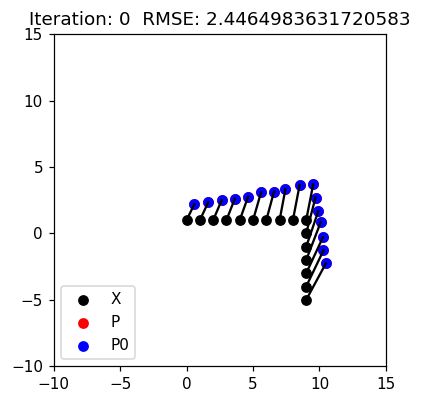

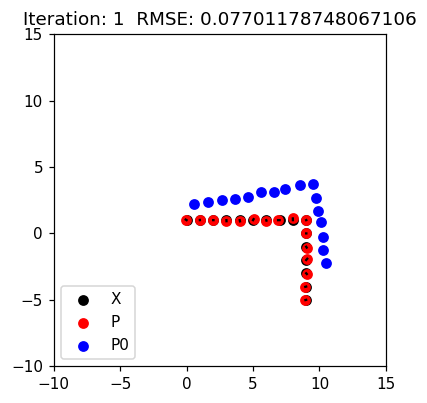

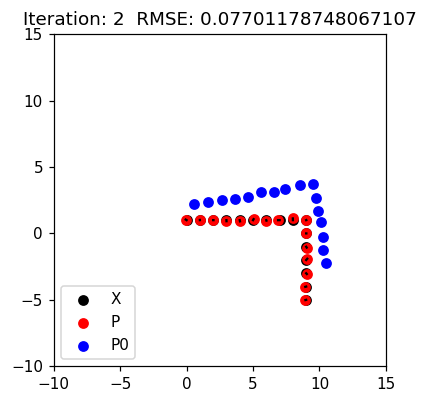

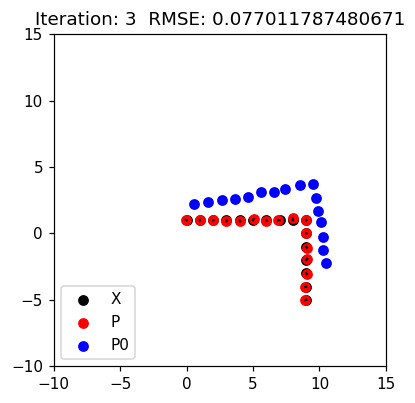

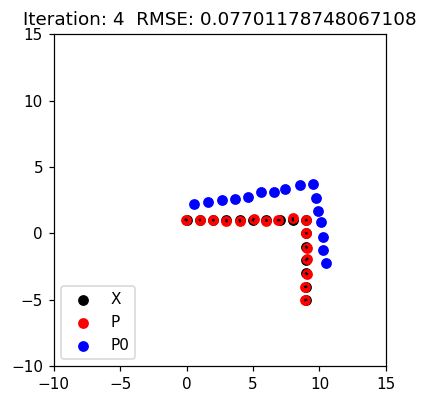

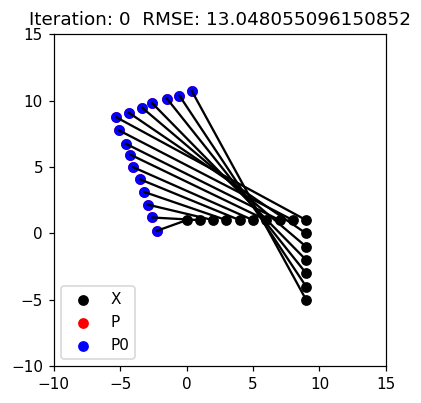

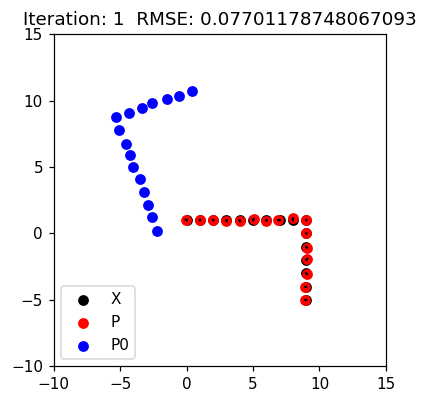

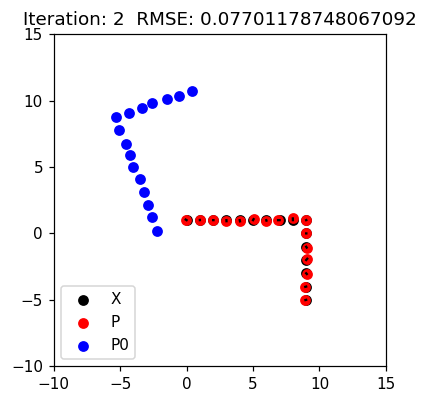

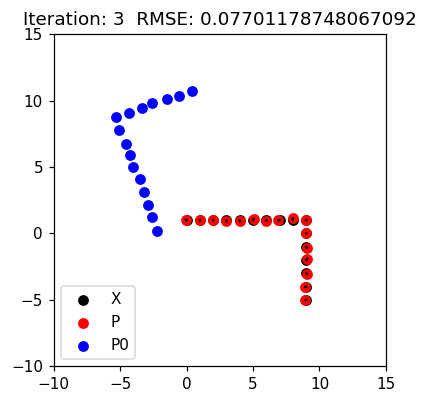

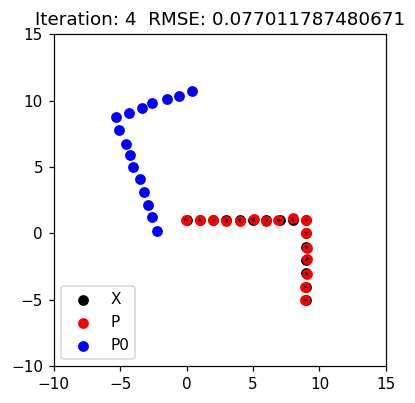

In [ ]:
# Call ICP on P1 & P2

ICP(X,P1) #Uncomment this
ICP(X,P2) #Uncomment this